### import libary

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, models
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

### make data for train , test

In [2]:
scale = MinMaxScaler(feature_range=(0, 1))

def sklearn_scaled(data, feature):
    # scale = MinMaxScaler(feature_range=(0, 1))
    for i in feature:
        data[i] = scale.fit_transform(data[i].values.reshape(-1, 1))
    return data

def split_data(data, data_range, train_ratio=0.8):
    split_range = int(len(data) * train_ratio)

    features = [
        'SMA_15', 'SMA_30', 'SMA_60', 'RSI', 'MACD', 'MACD_Signal',
        'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Volatility', 'Stochastic'
    ]
    data = sklearn_scaled(data, features)
    data = sklearn_scaled(data, ["Target"])

    pre_x_train = data.iloc[:split_range].loc[:,features]
    pre_y_train = data.iloc[:split_range].loc[:,["Target"]]
    pre_x_test = data.iloc[split_range:].loc[:,features]
    pre_y_test = data.iloc[split_range:].loc[:,["Target"]]
    pre_date = data.iloc[split_range:].index.to_list()
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    date = []
    for i in range(len(pre_x_train)-data_range):
        # x_tmp = np.transpose(pre_x_train.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_train.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_train.iloc[i+data_range-1].to_numpy()
        x_train.append(x_tmp)
        y_train.append(y_tmp)

    for i in range(len(pre_x_test)-data_range):
        # x_tmp = np.transpose(pre_x_test.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_test.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_test.iloc[i+data_range-1].to_numpy()
        x_test.append(x_tmp)
        y_test.append(y_tmp)
        date.append(pre_date[i+data_range-1])

    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape(-1)
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape(-1)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test, date

def prepar_data(asset, start, end):
    data = yf.download(asset, start=start, end=end)
    # data['Return'] = data['Close'].pct_change()
    data['SMA_15'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=15)
    data['SMA_30'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=30)
    data['SMA_60'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=60)
    data['RSI'] = ta.RSI(data['Close'].to_numpy().flatten(), timeperiod=14)
    data['MACD'], data['MACD_Signal'], _ = ta.MACD(data['Close'].to_numpy().flatten(), fastperiod=12, slowperiod=26, signalperiod=9)
    data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['Close'].to_numpy().flatten(), timeperiod=20)
    data['Momentum'] = ta.MOM(data['Close'].to_numpy().flatten(), timeperiod=10)
    data['Volatility'] = ta.ATR(data['High'].to_numpy().flatten(), data['Low'].to_numpy().flatten(), data['Close'].to_numpy().flatten(), timeperiod=14)
    data['Stochastic'] = ta.STOCH(data['High'].to_numpy().flatten(), data['Low'].to_numpy().flatten(), data['Close'].to_numpy().flatten(), fastk_period=14, slowk_period=3)[0]
    data["Target"] = data["Close"][asset].shift(-1)
    data.dropna(inplace=True)
    return data

In [3]:
data = prepar_data("GC=F", '2014-01-01', '2024-11-25')

[*********************100%***********************]  1 of 1 completed


In [4]:
x_train, y_train, x_test, y_test, date = split_data(data.copy(), data_range=30, train_ratio=0.5)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(date))

(1310, 30, 12) (1310,) (1310, 30, 12) (1310,)
(1310, 30, 12) (1310,) (1310, 30, 12) (1310,) 1310


### train model

In [5]:
def model_lstm(range_input=30, neurons=16, n_feature=3):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(range_input, n_feature)))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
    return model

# model = model_lstm(range_input=x_train.shape[1], n_feature=x_train.shape[2])
# history = model.fit(x_train, y_train, batch_size=500, epochs=100)

In [6]:
model = models.load_model("model/simple_lstm_model.h5")

plot graph true close price and predict close price

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


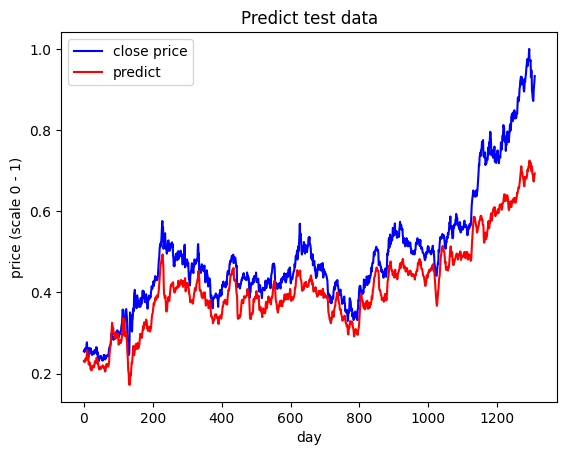

In [7]:
scale_predict = model.predict(x_test)
plt.plot(y_test, c="b", label="close price")
plt.plot(scale_predict, c="r", label="predict")
plt.title("Predict test data")
plt.xlabel("day")
plt.ylabel("price (scale 0 - 1)")
plt.legend()

In [8]:
# model.save("model/simple_lstm_model.h5")

### back test

In [9]:
scale_predict = model.predict(x_test)
capital = 10  # Initial capital
capital_history = []

csv_capital = {
    "date":[],
    "price_today":[],
    "price_next_day":[],
    "scale_day_change":[],
    "capital_befor":[],
    "capital_after":[],
    "profit":[],
    "action":[]
    }

for i in range(len(scale_predict) - 1):
    price_today = data["Close"]["GC=F"].loc[date[i]]
    price_next_day = data["Close"]["GC=F"].loc[date[i+1]]

    day_change = (scale_predict[i+1]-scale_predict[i])[0]
    
    csv_capital["date"].append(date[i])
    csv_capital["price_today"].append(price_today)
    csv_capital["price_next_day"].append(price_next_day)
    csv_capital["scale_day_change"].append(day_change)
    csv_capital["capital_befor"].append(capital)

    if abs(day_change) > 0.002:
        capital *= 0.999
        if day_change > 0:
            csv_capital["action"].append("Long")
            profit = (price_next_day - price_today) / price_today * capital
        else:
            csv_capital["action"].append("Short")
            profit = (price_today - price_next_day) / price_today * capital
        csv_capital["profit"].append(profit)
        capital += profit
        capital *= 0.999
    else:
        csv_capital["profit"].append(0)
        csv_capital["action"].append("None")
    
    csv_capital["capital_after"].append(capital)
    
    capital_history.append(capital)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


save result csv

In [10]:
csv_capital = pd.DataFrame(csv_capital)
csv_capital.to_csv("csv_file/lstm_back_test.csv", index=False)

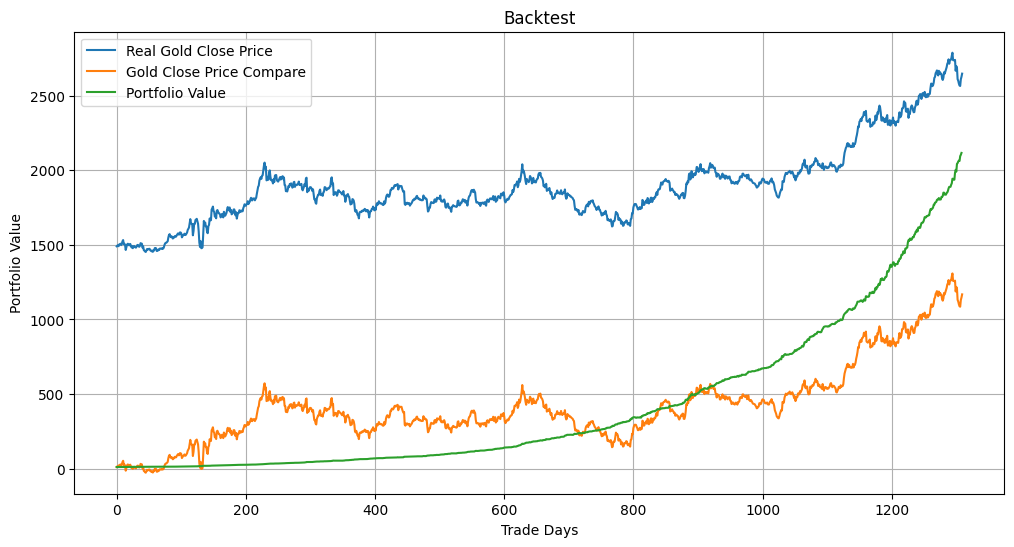

In [59]:
gold_close_price = data["Close"]
gold_close_price = gold_close_price["GC=F"]
gold_close_price = gold_close_price.loc[date].to_numpy()

# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(gold_close_price, label="Real Gold Close Price")
plt.plot(gold_close_price - (gold_close_price[0]-capital_history[0]), label="Gold Close Price Compare")
plt.plot(capital_history, label='Portfolio Value')
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

### calculate CAGR , Max Drawdown , SD

In [ ]:
import cal_def
import math

cagr = cal_def.cal_cagr(capital_history)
max_dd = cal_def.cal_max_drawdown(capital_history)
sd = cal_def.cal_sd(capital_history) * math.sqrt(250)

print(f"CAGR : {cagr:.3f}")
print(f"Max Drawdown : {max_dd[0]:.3f}")
print(f"\tStart day : {max_dd[1]}\n\tEnd day : {max_dd[2]}")
print(f"SD : {sd:.3f}")

CAGR : 1.781
Max Drawdown : 0.028
	Start day : 128
	End day : 129
SD : 8044.902
